In [1]:
import keras
import os, shutil
import numpy as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
import cv2

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
C:\Users\ARK\miniconda3\envs\ark\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import warnings
warnings.filterwarnings(action='ignore')


import tensorflow as tf
 
 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [3]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [12]:
from keras.applications import VGG16
from keras import backend as K

layer_name = 'conv2d_4'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [13]:
# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
grads = K.gradients(loss, model.input)[0]
# 0 나눗셈을 방지하기 위해 1e–5을 더합니다
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [14]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [15]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

TypeError: show() got an unexpected keyword argument 'bbox_inches'

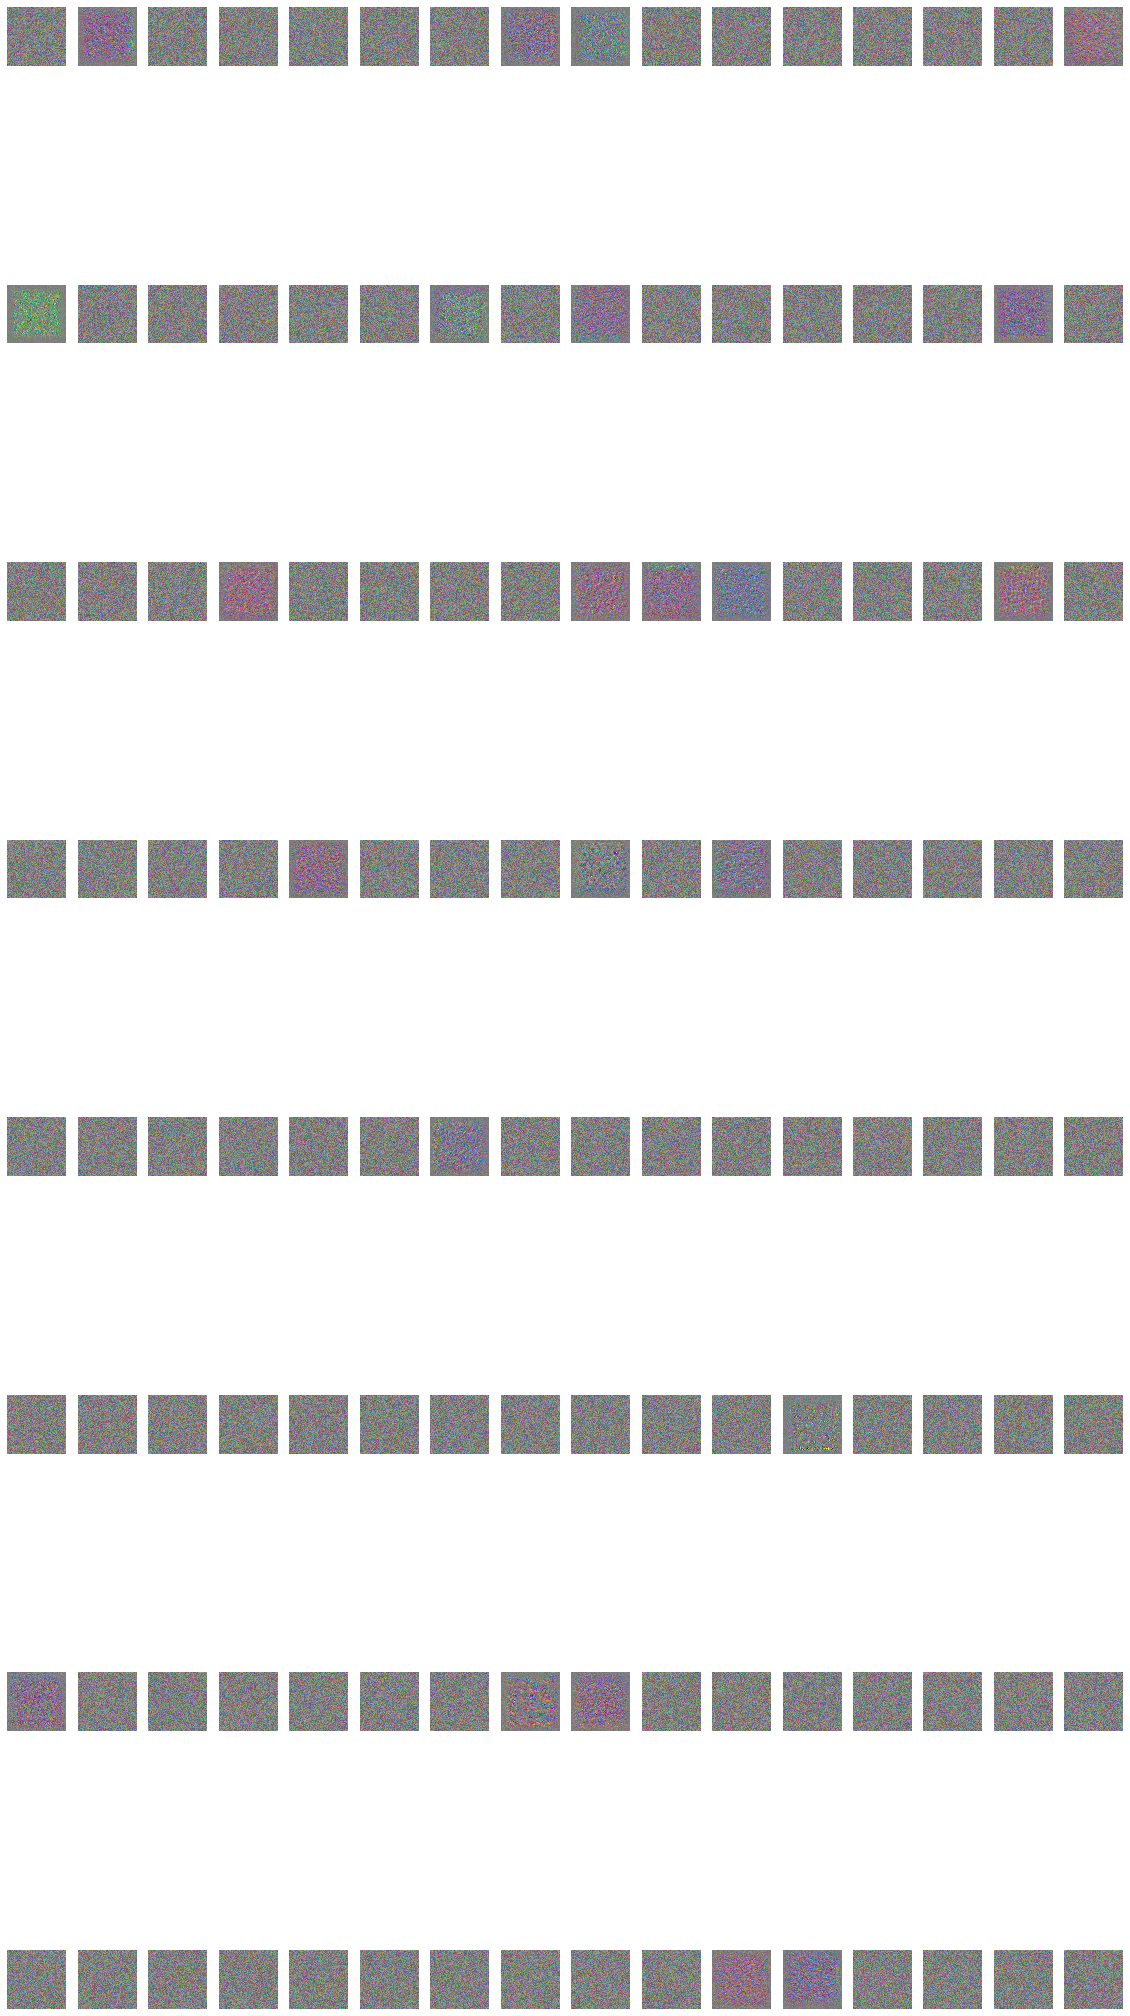

In [29]:
plt.figure(figsize=(20, 40))
for i in range(128):
    plt.subplot(8,16,i+1)
    plt.imshow(generate_pattern('conv2d_4', i))
    plt.axis('off')
plt.show(bbox_inches='tight')

In [23]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
folder_path = './10_test'
# 이미지 경로
img_path = folder_path + '/dogs/1.jpg'

img = image.load_img(img_path, target_size=(150, 150))

# (224, 224, 3) 크기의 넘파이 float32 배열
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


In [24]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
        folder_path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
validation_generator

Found 20 images belonging to 2 classes.


In [25]:
img, label = validation_generator.next()
X=[]
y=[]
for i in range(20):
    #print(i, ":", label[i])
    #plt.imshow(img[i])
    #plt.show()
    X.append(img[i].reshape((1,) + img[i].shape))
    y.append(label[i])

In [26]:
def create_heatmap(input_image, pred,k):
    max_arg= np.argmax(pred[0])
    output = model.output[:, max_arg]
    last_conv_layer= model.get_layer('conv2d_4')
    grads = K.gradients(output, last_conv_layer.output)[0]


    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])


    pooled_grads_value, conv_layer_output_value = iterate([input_image])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # cv2 모듈을 사용해 원본 이미지를 로드합니다
    img = input_image.reshape(150,150,3)
    img = img*255
    #img = cv2.imread('10_test/cats/6.jpg')
    # heatmap을 원본 이미지 크기에 맞게 변경합니다
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # heatmap을 RGB 포맷으로 변환합니다
    heatmap = np.uint8(255 * heatmap)

    # 히트맵으로 변환합니다
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4는 히트맵의 강도입니다
    superimposed_img = heatmap * 0.5 + img

    # 디스크에 이미지를 저장합니다
    cv2.imwrite('heatmap/heatmap_'+str(k)+'.jpg', superimposed_img)
    plt.imshow(superimposed_img/255)
    plt.show()

0 번째 예측


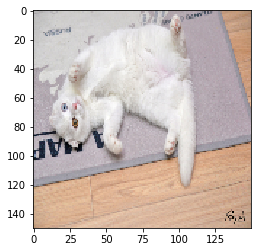

이미지 Label : 0.0
예측한 Label : [[0.]], ([[0.15096651]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


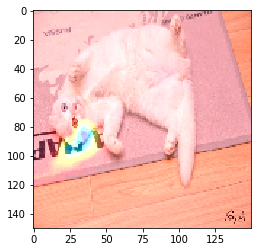

1 번째 예측


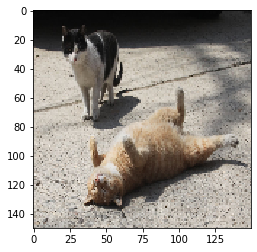

이미지 Label : 0.0
예측한 Label : [[1.]], ([[0.9142488]])
예측이 틀렸습니다


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


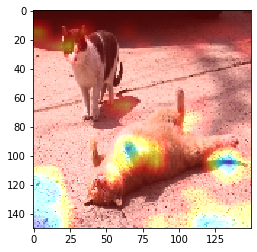

2 번째 예측


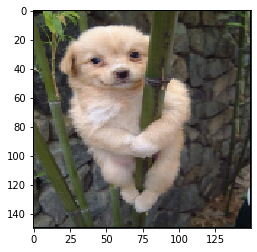

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.9650445]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


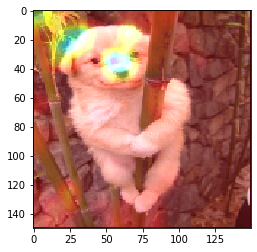

3 번째 예측


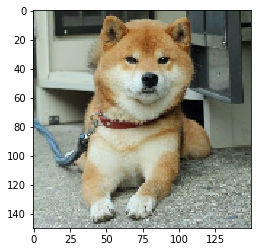

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.9973405]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


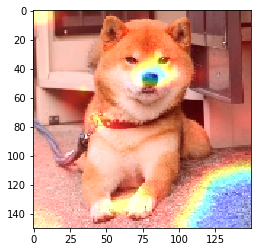

4 번째 예측


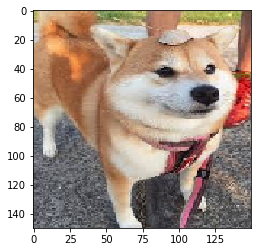

이미지 Label : 1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



예측한 Label : [[1.]], ([[0.9879771]])
예측이 맞았습니다.


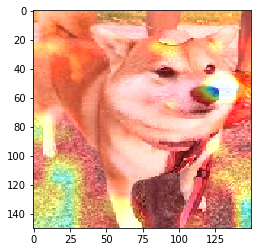

5 번째 예측


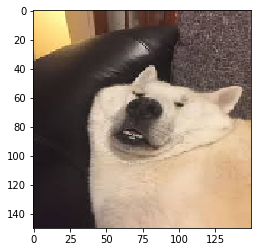

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.52400094]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


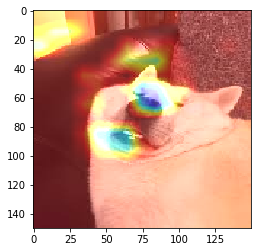

6 번째 예측


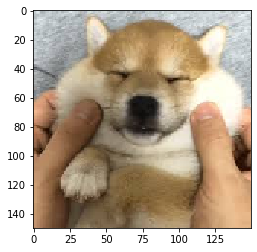

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.50643206]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


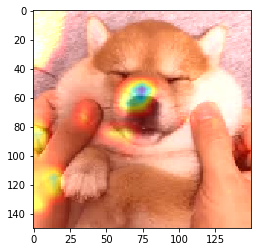

7 번째 예측


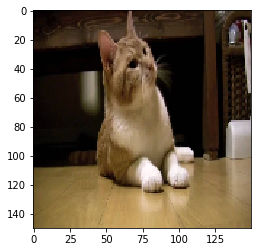

이미지 Label : 0.0
예측한 Label : [[1.]], ([[0.63798606]])
예측이 틀렸습니다


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


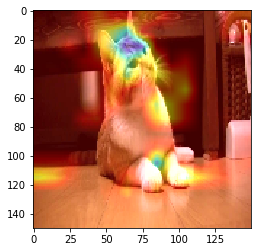

8 번째 예측


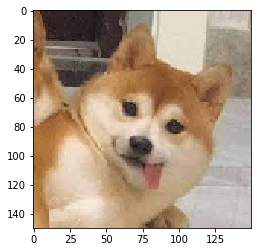

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.8651641]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


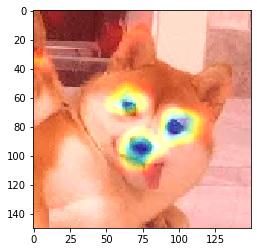

9 번째 예측


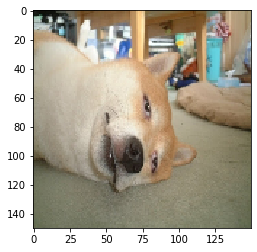

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.98148835]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


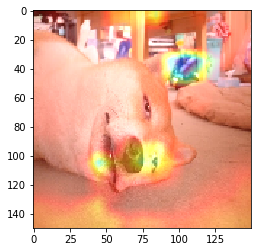

10 번째 예측


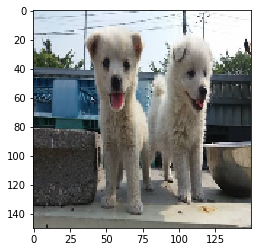

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.7508434]])
예측이 맞았습니다.


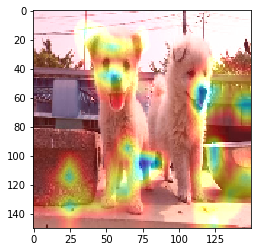

11 번째 예측


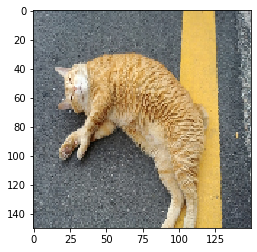

이미지 Label : 0.0
예측한 Label : [[1.]], ([[0.98333794]])
예측이 틀렸습니다


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


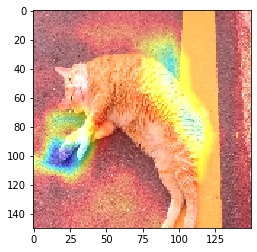

12 번째 예측


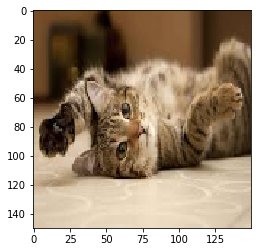

이미지 Label : 0.0
예측한 Label : [[0.]], ([[0.2589707]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


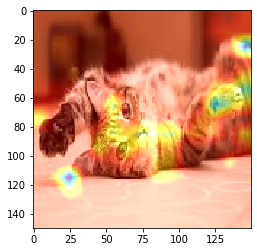

13 번째 예측


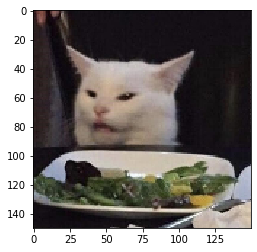

이미지 Label : 0.0
예측한 Label : [[0.]], ([[0.4184933]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


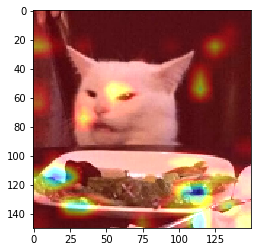

14 번째 예측


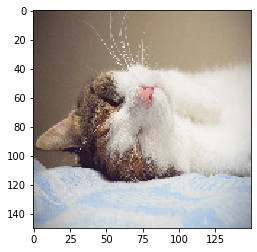

이미지 Label : 0.0
예측한 Label : [[0.]], ([[0.01340732]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


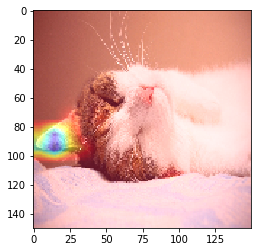

15 번째 예측


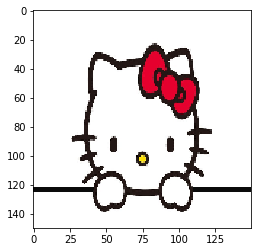

이미지 Label : 0.0
예측한 Label : [[0.]], ([[0.29382917]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


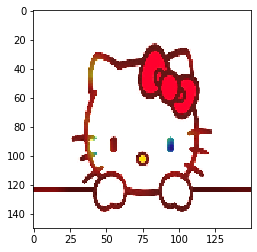

16 번째 예측


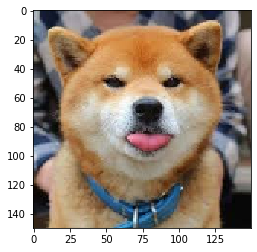

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.9901244]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


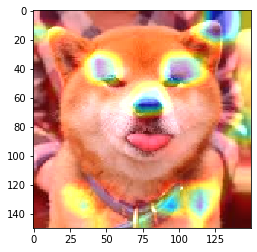

17 번째 예측


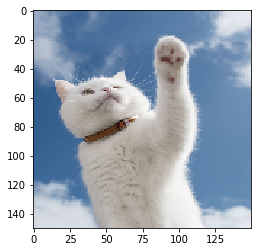

이미지 Label : 0.0
예측한 Label : [[0.]], ([[0.35603422]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


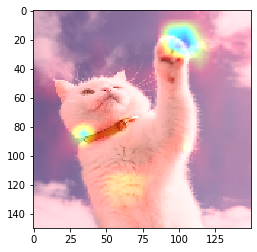

18 번째 예측


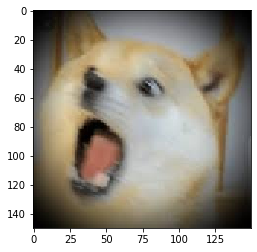

이미지 Label : 1.0
예측한 Label : [[1.]], ([[0.7282]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


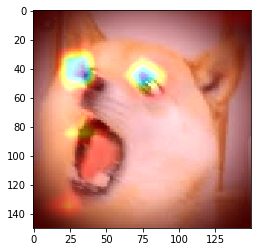

19 번째 예측


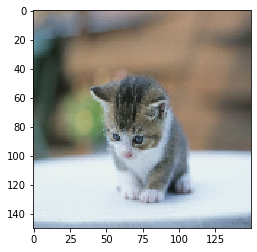

이미지 Label : 0.0
예측한 Label : [[0.]], ([[0.02341067]])
예측이 맞았습니다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


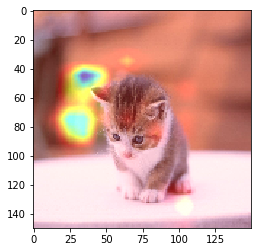

맞은 개수 : 17, 틀린 개수 : 3


In [27]:
o=0
x=0
for i in range(20):
    print("{} 번째 예측".format(i))
    plt.imshow(X[i].reshape(150,150,3))
    plt.show()
    pred = model.predict(X[i])
    print("이미지 Label : {}".format(y[i]))
    print("예측한 Label : {}, ({})".format(np.round(pred), pred))
    if np.round(pred) == y[i]: 
        print("예측이 맞았습니다.") 
        o+=1
    else: 
        print("예측이 틀렸습니다")
        x+=1
    create_heatmap(X[i], pred, i)
    print("======================")
print("맞은 개수 : {}, 틀린 개수 : {}".format(o,x))